# Get satellite rainfall estimates

This notebook allows for downloading of rainfall estimates product from different providers, and preprocessing for their direct use in crop simulation models of the SARRA family (SARRA-O, SARRA-Py). That is to say the output format is a series of geotiff files, one per day, with the same spatial resolution as the input data. The output files are stored in the './data/3_output/' directory.

Rainfall estimates products available :
- TAMSAT (https://www.tamsat.org.uk/)
- CHIRPS (https://www.chc.ucsb.edu/data/chirps)
- IMERG (https://gpm.nasa.gov/data/imerg)


## 1. Imports

In [3]:
import sys
from datetime import datetime
sys.path.append('../src/SARRA_data_download/')
from get_satellite_rainfall_estimates import *

## 2. Parameters

In [29]:
# defining dictionary of coordinates for areas of interest
# bounding box coordinates format : [lat NW, lon NW, lat SE, lon SE]
area = {
    'burkina': [16, -6, 9, 3],
    'niger':[23.8, -0.5, 11.3, 15.9],
    'west_africa':[29, -20, 3.5, 26],
    'mexico':[19.2, -93.9, 17.0, -90.2],
    'senegal':[16.7, -17.5, 12.3, -11.4],
    'north_cameroon':[13.3,10.7,5.7,16.2],
    'south_mali':[18.7,-12.4,10.1,4.5],
    'bande_sahel_RD':[15.7, -12.5, 8.3,14.8],
    'congo':[3.8, 10.8, -5.3, 18.8]} 

# selecting area of interest
selected_area = "north_cameroon"

# selecting year of interest
year_start = 1990
year_end = 1991

# defining save path
save_path = "../data/3_output/"

# IMERG credentials
# /!\ you must have a NASA Earthdata account to download IMERG data
# for access procedure see https://gpm.nasa.gov/sites/default/files/2021-01/arthurhouhttps_retrieval.pdf
username = "jeremy.lavarenne@cirad.fr"
password = "jeremy.lavarenne@cirad.fr"

## 3. Download

### 3.1 TAMSAT

In [3]:
# downloading data from TAMSAT, using the parallelized version of the download function
# (faster, uses as much workers as available cores)
for year in range(year_start,year_end+1):
    try:
        download_TAMSAT_year_parallel(year, area, selected_area, save_path)
    except:
        pass

 77%|███████▋  | 280/365 [01:58<00:43,  1.94it/s]

### 3.2 CHIRPS

In [10]:
# downloading data from CHIRPS, using the parallelized version of the download function
# (faster, uses as much workers as available cores)
for year in range(year_start, year_end+1):
    try:
        download_CHIRPS_year_parallel(year, area, selected_area, save_path)
    except:
        pass

100%|██████████| 365/365 [03:38<00:00,  1.67it/s]


### 3.3 IMERG

In [ ]:
# downloading data from IMERG
download_IMERG_year(year, area, selected_area, save_path, username, password)

### 3.4. Beta version of PrISM data handling

In [ ]:
# downloading data from PrISM
# download the files from the last Zenodo repository
# /!\ only years 2010 to 2021 are available so far

save_path = "../data/0_downloads/PrISM/"
year = 2014

if year < 2010 or year > 2021:
    raise ValueError("PrISM data is only available for years 2010 to 2021")

URL_filename = "PrISM_Rainfall_SMOS-L3SM_"+str(year)+"_010d_Africa.nc.gz"
URL_full = "https://zenodo.org/record/5998113/files/"+URL_filename+"?download=1"

# if save_path does not exist, we create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

response = requests.get(URL_full, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 Kibibyte
progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

save_filename = URL_filename
with open(os.path.join(save_path,save_filename), 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)

progress_bar.close()

if total_size != 0 and progress_bar.n != total_size:
    print("Download failed.")
else:
    print("Download complete.")

In [6]:
# extract the downloaded file to the extract_path
extract_path = "../data/1_extraction/PrISM/"

# if extract_path does not exist, we create it
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with gzip.open(os.path.join(save_path,save_filename), 'rb') as f_in:
    with open(os.path.join(extract_path,save_filename[:-3]), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [36]:
import rioxarray as rxr
# open the extracted netcdf file with rioxarray, and clip it to the area of interest as defined with area[selected_area]
# define box according to the coordinates neded by rioxarray.clip_box
box = [area[selected_area][1], area[selected_area][2], area[selected_area][3], area[selected_area][0]]
ds = rxr.open_rasterio(os.path.join(extract_path,save_filename[:-3]), masked=True).rio.write_crs("epsg:4326").rio.clip_box(*box)

In [38]:
# delete ds units attribute    
ds['rainfall'].attrs['units'] = None

In [44]:
# Compute the sum every 8 images
group_size = 8
summed_data = ds.coarsen(time=group_size, boundary='trim').sum()

In [ ]:
#save each image as a geotiff file
save_path = "../data/3_output/PrISM_{}/".format(selected_area)
if not os.path.exists(save_path):
    os.makedirs(save_path)

date = datetime.date(year,1,1)

for i in tqdm(range(0, len(summed_data['time']))):
    # save the image as a geotiff file
    filename = "PrISM_rainfall_{}_{}_{}_{}.tif".format(selected_area, date.year, date.strftime("%m"), date.strftime("%d"))
    da = summed_data['rainfall'][i,:,:].drop('time')
    da.attrs = {}
    da.rio.to_raster(os.path.join(save_path,filename))
    date = date + datetime.timedelta(days=1)

### 3.5. To Do

In [ ]:
# downloading data from PERSIANN
# to be implemented : https://persiann.eng.uci.edu/CHRSdata/PERSIANN/daily/

## 4. Loading data into xarrays

In [3]:
# parameters of our time series
date_start = datetime.date(2014,1,1)
duration = 365

In [4]:
# retreiving grid size of the most finely resoluted dataset (here, TAMSAT)
rainfall_path = "../data/3_output/TAMSAT_v3.1_niger_rfe_filled/"
grid_width, grid_height = get_grid_size(rainfall_path, date_start, duration)

In [5]:
# loading TAMSAT data into a xarray dataset
data = xr.Dataset()
data = load_TAMSAT_data(data, rainfall_path, date_start, duration)

In [6]:
# loading CHIRPS data into the "data" xarray dataset
rainfall_path = "../data/3_output/CHIRPS_v2.0_Africa_niger"
new_var_name = "rain_CHIRPS"
data = load_lower_res_rain_data(data, rainfall_path, date_start, duration, new_var_name)

In [7]:
# loading IMERG data into into the "data" xarray dataset
rainfall_path = "../data/3_output/IMERG_niger_band_data"
new_var_name = "rain_IMERG"
data = load_lower_res_rain_data(data, rainfall_path, date_start, duration, new_var_name)

In [8]:
# loading PrISM data into into the "data" xarray dataset
rainfall_path = "../data/3_output/PrISM_niger"
new_var_name = "rain_PrISM"
data = load_lower_res_rain_data(data, rainfall_path, date_start, duration, new_var_name)

## 5. Plotting results

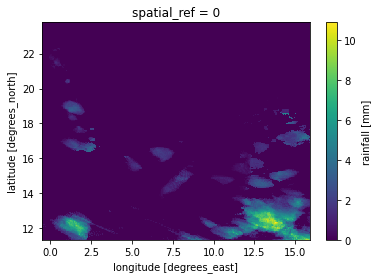

In [9]:
# plotting day #200 of the TAMSAT dataset
data["rain"][200,:,:].plot()

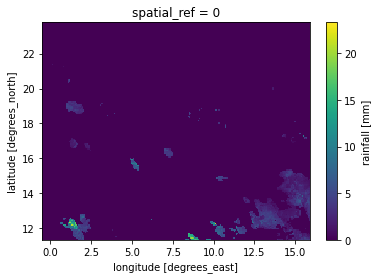

In [10]:
# plotting day #200 of the CHIRPS dataset
data["rain_CHIRPS"][200,:,:].plot()

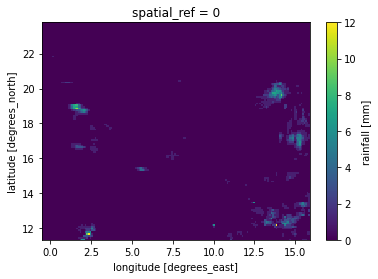

In [12]:
# plotting day #200 of the IMERG dataset
data["rain_IMERG"][200,:,:].plot()

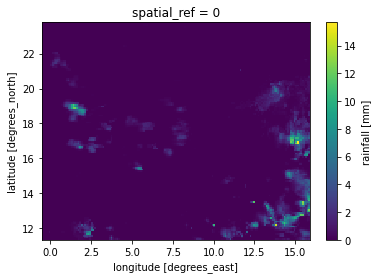

In [13]:
# plotting day #200 of the IMERG dataset
data["rain_PrISM"][200,:,:].plot()